In [1]:
# Comparing Isolation Forest and Extended Isolation Forest with generated data

In [2]:
N = 500
ntrees = 400
sample_size = 256
seed = 42

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import h2o
import math
import random
from h2o.estimators import H2OIsolationForestEstimator, H2OExtendedIsolationForestEstimator
from sklearn.datasets import make_blobs

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,32 mins 20 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_scotthardy_epu5ti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.161 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


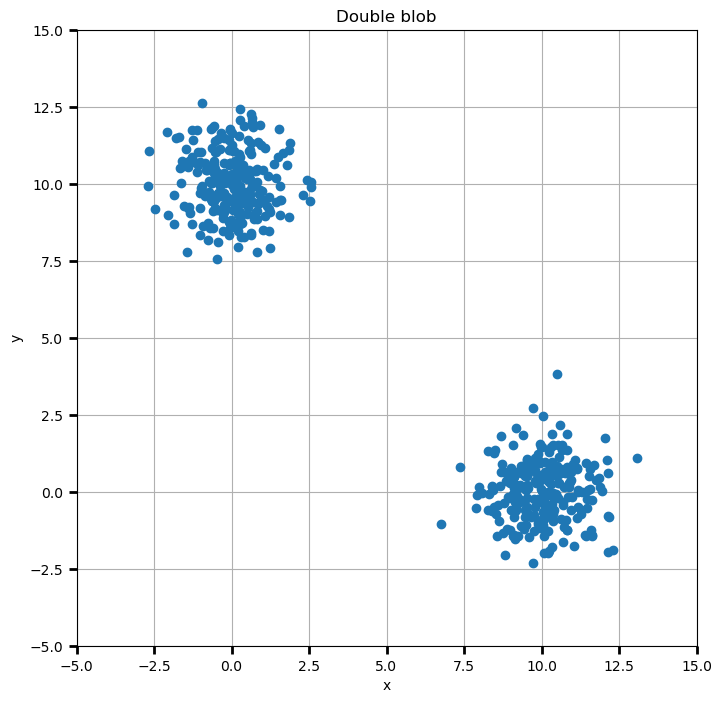

In [5]:
# Define datasets
blobs_params = dict(random_state=seed, n_samples=N, n_features=2)
data = make_blobs(centers=[[10, 0], [0, 10]], cluster_std=[1, 1], **blobs_params)[0]

fig=plt.figure(figsize=(8,8))
fig.add_subplot(111)
plt.plot(data[:,0],data[:,1],'o')
plt.grid("off")
# plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2)
plt.title("Double blob")
plt.show()

In [6]:
training_frame = h2o.H2OFrame(data,column_names = ["x", "y"])

EIF_h2o = H2OExtendedIsolationForestEstimator(
                                              model_id = "extended_isolation_forest.hex",
                                              ntrees = ntrees, 
                                              sample_size = sample_size,
                                              extension_level = 1,
                                              seed = seed
                                             )
EIF_h2o.train(training_frame = training_frame)

IF_h2o = H2OExtendedIsolationForestEstimator(
                                              model_id = "isolation_forest.hex",
                                              ntrees = ntrees, 
                                              sample_size = sample_size,
                                              extension_level = 0,
                                              seed = seed
                                             )
IF_h2o.train(training_frame = training_frame)

print(EIF_h2o)
print(IF_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Model Details
H2OExtendedIsolationForestEstimator : Extended Isolation Forest
Model Key: extended_isolation_forest.hex


Model Summary: 
    number_of_trees    size_of_subsample    extension_level    seed    number_of_trained_trees    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves    min_isolated_point    max_isolated_point    mean_isolated_point    min_not_isolated_point    max_not_isolated_point    mean_not_isolated_point    min_zero_splits    max_zero_splits    mean_zero_splits
--  -----------------  -------------------  -----------------  ------  -------------------------  -----------  -----------  ------------  ------------  ------------  -------------  ---------------

In [7]:
granularity = 30

# Heat map data 
xx, yy = np.meshgrid(np.linspace(-5, 15, granularity), np.linspace(-5, 15, granularity))

# H2O
hf_heatmap = h2o.H2OFrame(np.c_[xx.ravel(), yy.ravel()], column_names = ["x", "y"]) 

h2o_anomaly_score_eif = EIF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_eif = h2o_anomaly_score_eif.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_eif = np.array(h2o_anomaly_score_df_eif["anomaly_score"]).reshape(xx.shape)

h2o_anomaly_score_if = IF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_if = h2o_anomaly_score_if.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_if = np.array(h2o_anomaly_score_df_if["anomaly_score"]).reshape(xx.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


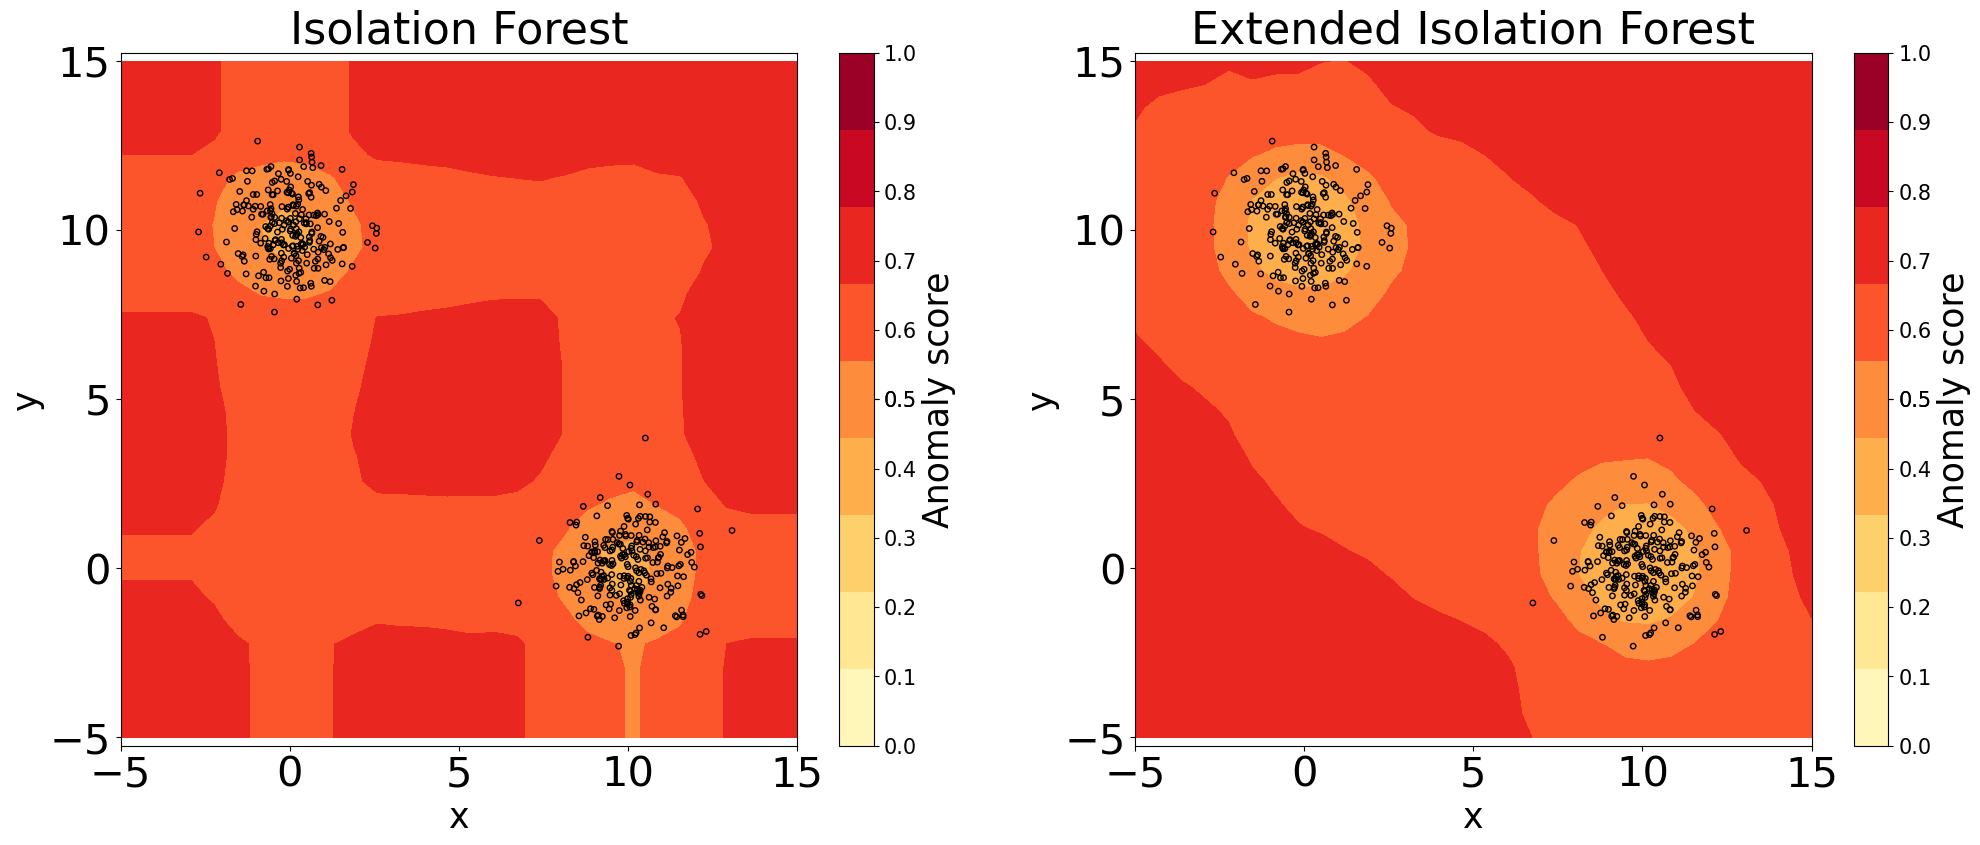

In [8]:
f = plt.figure(figsize=(24, 9))

def plot_heatmap(heatmap_data, subplot, title): 
    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,10, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 25)
    cbar.ax.tick_params(labelsize=15)
    ax1.set_xlabel("x", fontsize = 25)
    ax1.set_ylabel("y", fontsize = 25)
    plt.tick_params(labelsize=30)
    plt.scatter(data[:,0],data[:,1],s=15,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=32)
    
plot_heatmap(heatmap_h2o_if, 121, "Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 122, "Extended Isolation Forest")

plt.show()